#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H=13
Xg = L/2 # [m]
mn =   27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [11]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
# Irho+=vessel_inertia

In [16]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [17]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [18]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [19]:
E = 210e9

In [20]:
E*Ar

16991625880.187403

In [21]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [22]:
DT=np.diag(diag_DT) # (35) in [2]

In [23]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [24]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [25]:
CT=np.diag(diag_CT)

In [26]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [27]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [28]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [29]:
rng = np.random.default_rng()

In [30]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [31]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [32]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.28347845,  0.28265603, -0.91637631],
       [ 0.55075432,  0.73428146,  0.39686323],
       [ 0.78505392, -0.61720038,  0.05247894]])

In [33]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.007066


In [34]:
Ret.shape

(50, 3, 3)

In [35]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [36]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64))) 
    return ans.T

In [37]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000604


In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[ 3.19350627e+03, -3.48521930e+03,  9.59192811e+03],
       [ 7.01569993e+02,  5.72866095e+03,  7.29825688e+02],
       [-4.17375990e+03,  3.24610981e+03,  4.12517095e+03],
       [ 5.25303246e+03, -9.63812191e+03,  2.53368380e+04],
       [ 7.78588137e+03, -2.56477608e+03, -1.81137677e+04],
       [ 6.23572505e+03, -2.87837241e+03, -4.74286459e+03],
       [ 2.08814383e+03,  5.68031990e+02,  1.08470430e+04],
       [ 2.57365355e+03,  4.21366411e+04, -1.99179410e+04],
       [-8.17176244e+03,  6.23987286e+00,  8.69936284e+02],
       [ 1.30162292e+03,  2.60952271e+04, -1.86062157e+04],
       [ 1.09480851e+00,  2.88921364e+04, -1.43871313e+04],
       [ 5.22086249e+03, -2.54692040e+03, -1.81454479e+03],
       [ 8.24191793e+02, -7.89215011e+02,  2.38116867e+02],
       [-6.04155127e+03, -2.94630097e+02, -1.29016175e+02],
       [-2.11349137e+02,  9.28983724e+02,  9.06189125e+02],
       [-2.05565730e+04, -2.32785834e+04,  1.38944310e+04],
       [-2.41404585e+02,  2.16833882e+04

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000337


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000409


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR) 

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000098


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float64))

In [55]:
phi(x,y,z,Ret,None,None)

array([[ 8.22490412e-01,  2.51298525e-03, -9.48593069e-01],
       [ 2.22790526e-01, -1.29959901e+00, -3.10846139e-01],
       [ 3.32457122e-01, -4.40271451e-01,  7.78218702e-02],
       [-1.35826723e+00, -1.18274843e+00,  6.45499765e-01],
       [-2.16185357e-01,  7.34957107e-01,  3.98122599e-01],
       [-6.22018737e-01,  1.22708563e-01,  1.07123574e+00],
       [-3.37944231e-01,  1.74880299e+00, -4.34065897e-01],
       [ 4.13952823e-02, -1.61727082e+00, -2.66967214e+00],
       [-1.41835281e+00, -6.76193040e-01, -1.95311633e-01],
       [-2.81456955e-01,  2.58272248e-01, -1.08195054e-01],
       [ 2.00571713e+00,  1.03908267e+00, -1.24111559e-01],
       [-2.10241659e+00,  6.37924048e-01, -2.02488288e-01],
       [ 1.62249182e-02, -4.50250334e-01,  1.17689290e+00],
       [-4.46740213e-01,  3.76766285e-01,  4.18396706e-01],
       [ 1.14861354e-01,  1.75748344e+00,  1.17978924e+00],
       [ 9.98816499e-01, -4.61236104e-01, -3.16823354e-01],
       [-1.12410579e+00,  5.69000816e-01

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000315


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.001802


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.001670


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[-0.48201167, -1.93611262, -1.36010375],
       [ 0.70839751, -1.01401282,  0.78379681],
       [-0.15997841,  1.64886615,  1.43321284],
       [-0.14093912, -1.04314808, -0.01786813],
       [ 0.317674  ,  3.55337218,  1.69353023],
       [ 0.19650096,  0.62268057,  0.1857578 ],
       [ 0.16204211,  1.33205825, -0.75796727],
       [ 0.63236952, -2.63706128, -1.00998492],
       [ 0.21744512,  0.20032442, -0.67005288],
       [ 0.74195812, -0.90494116,  0.74644764],
       [ 0.55663147,  0.20921438, -0.40191446],
       [ 0.96953853,  1.24157479, -0.83505031],
       [ 0.18790045, -0.77847605,  0.61422444],
       [-0.66048238, -0.71714595, -0.57836616],
       [-0.9309934 , -0.30343856, -0.41602078],
       [-1.17829969,  0.96579232,  0.56441752],
       [ 0.30558319,  1.51113716, -1.6238089 ],
       [-0.44331921, -0.80573671, -0.79411491],
       [-0.50716254, -0.65950466, -0.14220763],
       [ 0.42674421,  1.15577265, -0.84281611],
       [-0.03593884,  1.53257351, -1.286

In [63]:
def d_s(f,a,b,c,Ret,omega, force, flag=0): # here
    
    fun = f(a,b,c,Ret,omega, force) 
    
    if flag==1:
        fun+=-np.dot(Ret,force)
    elif flag==2:
        fun+=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
# #     print(fun)
#     if any(force):
# #         fun[-1]=-np.array(force)
#         fun[-1]=-np.dot(Ret[-1],force)
# #         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #     print(fun)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun.astype(np.float64)).T

In [64]:
φ, θ, ψ = np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None), [1,20,3],flag=2)

array([[ 2.68769693e-04, -1.85565333e-05,  2.57264977e-04,
         2.31034691e-04,  1.89965622e-04,  1.43478938e-04,
         1.47149093e-05,  1.83318555e-04,  8.34666106e-05,
        -6.43830275e-05,  8.04249455e-08, -4.00031648e-05,
         1.17564346e-04,  2.85233664e-04,  2.51777156e-04,
         2.43841906e-04, -1.95315120e-04,  1.72048937e-04,
         2.65432454e-04,  2.38448457e-05,  1.36778866e-04,
         1.68901512e-04,  2.55964214e-04,  8.36227406e-05,
         3.57378710e-05,  2.24863372e-04,  1.01079812e-05,
        -1.45998359e-04,  2.76174148e-04, -2.58691028e-04,
        -1.15924650e-04,  1.81947602e-04,  8.11416094e-05,
         1.25631705e-04, -9.14088211e-05, -1.56939312e-05,
         7.02847305e-05,  1.89543761e-04,  2.65426280e-04,
         2.39293042e-04,  8.12175180e-05,  7.47054841e-05,
         1.70449135e-04, -5.93226117e-05,  1.86154487e-04,
         2.45099254e-04,  2.36114823e-04,  1.68021871e-04,
        -2.21690686e-05,  2.84910973e-04],
       [-1.28

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,0])
print(datetime.now() - startTime1)

0:00:00.002835


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega,force,flag=1).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,0])

array([[ 6.32921993e-07,  2.73905372e-07,  8.17227583e-07,
         7.68739284e-07, -6.39043722e-07,  1.49122757e-06,
        -1.08394773e-06,  4.02260098e-06,  2.38179449e-07,
        -2.71563833e-07,  7.79319297e-08, -7.46941384e-07,
         6.70550431e-07, -1.39545685e-07,  5.88452451e-07,
         3.89671418e-07,  6.73003720e-07,  1.39383594e-07,
        -6.14321027e-07,  7.96629069e-07,  9.57553946e-07,
        -5.30121151e-08,  1.50408859e-06, -1.66944604e-06,
         1.50432493e-06, -1.37018704e-06,  8.11976889e-07,
         2.82840932e-06, -3.16458930e-06, -3.23217321e-07,
         1.02371118e-06,  6.65610358e-07, -4.74576264e-07,
         5.23082880e-07, -2.09875567e-06, -5.13074373e-07,
         4.78016274e-07,  3.47063831e-07,  2.32374196e-06,
        -9.56253821e-07,  1.42265926e-06, -2.81515213e-09,
        -6.13294458e-07,  1.92703649e-06, -7.48913386e-08,
        -1.96048798e-06,  2.96275063e-07, -9.71185645e-07,
         1.55258235e-06, -2.50133374e-06],
       [ 9.39

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[-3.19350627e+03, -7.01569993e+02,  4.17375990e+03,
        -5.25303246e+03, -7.78588137e+03, -6.23572505e+03,
        -2.08814383e+03, -2.57365355e+03,  8.17176244e+03,
        -1.30162292e+03, -1.09480851e+00, -5.22086249e+03,
        -8.24191793e+02,  6.04155127e+03,  2.11349137e+02,
         2.05565730e+04,  2.41404585e+02, -5.64426218e+03,
         1.49037101e+04, -8.84910526e+00,  3.18433190e+03,
         9.52212050e+02, -3.24975027e+04,  1.99131306e+04,
        -5.00968220e+03, -5.94156388e+03, -2.67903357e+03,
         1.06631117e+04,  2.88456761e+03, -1.05294759e+02,
         1.48294868e+03,  2.97711753e+03, -3.99750650e+00,
         3.12349051e+03,  1.26030937e+03,  1.05437856e+03,
        -3.90202416e+02,  9.87208242e+03, -6.03687380e+03,
        -1.56363373e+02, -3.49933094e+04, -1.15930130e+04,
         7.79947433e+03, -2.58003120e+03, -7.37700619e+03,
         1.43897712e+01,  1.29496287e+02,  2.80197130e+03,
        -5.61313220e+03,  1.93063311e+04],
       [ 3.48

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.002568


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None), [0,0,1]).T

array([[ 2.94785950e+02, -2.06182854e+01, -2.74168254e+02],
       [-2.02000747e+02, -2.66401229e+02,  4.68402380e+02],
       [-1.02001231e+02, -2.12357893e+00,  1.04125014e+02],
       [-2.68775601e+01,  8.79202616e+01, -6.10426477e+01],
       [-2.86161495e+01, -1.86903959e+00,  3.04852463e+01],
       [ 6.26941267e+02, -8.29497843e+02,  2.02555321e+02],
       [ 3.96459480e+02, -7.08440115e+01, -3.25616261e+02],
       [ 2.16985747e+01,  4.11244167e+00, -2.58110598e+01],
       [-1.80528148e+02, -6.35916335e+02,  8.16444844e+02],
       [-2.27941550e+02, -3.56561108e+02,  5.84503114e+02],
       [-8.32779349e+01, -8.31796803e+02,  9.15074904e+02],
       [ 9.76237128e+01, -3.06799619e+02,  2.09175711e+02],
       [-2.03215521e+02, -7.38528188e+01,  2.77068746e+02],
       [ 1.22964045e+02, -2.97286284e+02,  1.74321993e+02],
       [ 7.08710640e+01, -4.30508518e+02,  3.59637313e+02],
       [ 3.96202703e+01, -4.44658748e+02,  4.05038399e+02],
       [ 1.38138390e+00, -5.62807553e+00

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-2.27778230e+07, -2.96957641e+08, -2.16211497e+06],
       [-3.90176694e+08,  7.82395964e+07, -1.23777940e+08],
       [-2.03132628e+06,  1.02090451e+08,  9.17876148e+04],
       [-1.18995577e+08, -1.80042446e+08, -2.06927904e+08],
       [-3.92304821e+04,  3.04356583e+07,  1.82976177e+06],
       [-4.68030250e+08, -2.65475571e+08,  3.61442437e+08],
       [-3.13442233e+07, -3.56954309e+08,  3.94986298e+07],
       [ 2.80428680e+05, -2.55250456e+07, -3.83221400e+06],
       [-4.67547151e+08,  3.48886877e+08,  1.68362930e+08],
       [-4.46433140e+08,  1.38084219e+08, -8.98708692e+07],
       [-6.77235071e+08,  2.37839538e+08,  1.54558176e+08],
       [-2.53554579e+08, -4.43778499e+07,  5.32469216e+07],
       [-4.29166655e+08, -1.52090339e+08, -3.55336665e+08],
       [-3.83571268e+08, -2.09271254e+08, -8.63057691e+07],
       [-4.26739581e+08, -6.71196073e+07,  3.74921577e+06],
       [-3.98159751e+08,  6.86364533e+06,  4.64828127e+07],
       [-5.62013242e+06, -1.37272734e+06

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000441


In [76]:
Re_b(Ret).shape

(50, 3, 3)

In [77]:
# def Irho_e(Ret):
    
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    
#     sum_=np.zeros(Irho.shape)
# #     print(sum_)
    
#     for i in range(len(ans1)):
#         sum_+=ans1[i]
#         ans1[i]=sum_
        
#     tmp=np.zeros(Irho.shape)
#     np.fill_diagonal(tmp, vessel_inertia)
    
#     ans2=np.multiply(np.multiply(Ret,tmp),Ret)
#     ans1[-1]+=ans2[-1]
    
#     for i in range(int(node_N/4)):
#         ans1[i]*=(10-i+1)
#     return ans1
def Irho_e(Ret): # here
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans

In [78]:
Irho_e(Ret)

array([[[8.03600296e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 5.39169258e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 5.50807750e-01]],

       [[5.33957198e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 4.66655454e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 3.74066301e+01]],

       [[1.60418432e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.09184369e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 5.54431904e-02]],

       [[2.41937174e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.63287299e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 4.86661807e+01]],

       [[1.15504652e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.02406459e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 3.66375886e-01]],

       [[6.02821169e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.14180503e+01, 0.00000000e+00],
    

In [79]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000285


In [80]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [81]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [82]:
def d_me(φ,θ,ψ,Ret,fun,omega,force):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,Ret,omega,force,flag=2)
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float64)) 

In [83]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None,None),[1,2,3])
print(datetime.now() - startTime1)

0:00:00.007636


In [84]:
d_me_

array([[ 2.81405962e+04,  8.67212770e+04, -1.40738157e+03],
       [-2.19871413e+05,  2.29278477e+05, -1.48775108e+04],
       [ 3.65610218e+03, -5.69455813e+04,  8.14026698e+01],
       [ 7.55918348e+03,  4.03739514e+05, -1.09589246e+05],
       [ 2.13436151e+02, -3.98816485e+05,  4.71089038e+02],
       [-1.02380885e+04,  1.13098346e+04,  2.98052129e+03],
       [ 3.46198753e+03, -1.31567893e+05,  9.08086311e+03],
       [ 3.91673036e+02,  3.95670814e+05, -1.89358495e+03],
       [-1.72460066e+05,  5.26712770e+04,  1.83548599e+05],
       [-2.55094883e+05,  1.92436554e+05, -6.10121828e+03],
       [-2.91420983e+05,  8.89274105e+04,  1.59861143e+05],
       [-9.73915459e+04, -6.42356457e+04,  3.17541251e+04],
       [-1.41100831e+05,  3.95456643e+05, -1.36213782e+05],
       [ 1.71442189e+05,  6.05761458e+04, -1.05243157e+05],
       [ 2.17687205e+05,  1.13040042e+04, -9.55179392e+04],
       [ 2.57833709e+05, -2.58735876e+04, -2.12561517e+04],
       [-4.39765696e+03, -1.75727730e+02

In [85]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [86]:
ne_(dx,dy,dz,DT,Ret)

array([[-3.19350627e+03, -7.01569993e+02,  4.17375990e+03,
        -5.25303246e+03, -7.78588137e+03, -6.23572505e+03,
        -2.08814383e+03, -2.57365355e+03,  8.17176244e+03,
        -1.30162292e+03, -1.09480851e+00, -5.22086249e+03,
        -8.24191793e+02,  6.04155127e+03,  2.11349137e+02,
         2.05565730e+04,  2.41404585e+02, -5.64426218e+03,
         1.49037101e+04, -8.84910526e+00,  3.18433190e+03,
         9.52212050e+02, -3.24975027e+04,  1.99131306e+04,
        -5.00968220e+03, -5.94156388e+03, -2.67903357e+03,
         1.06631117e+04,  2.88456761e+03, -1.05294759e+02,
         1.48294868e+03,  2.97711753e+03, -3.99750650e+00,
         3.12349051e+03,  1.26030937e+03,  1.05437856e+03,
        -3.90202416e+02,  9.87208242e+03, -6.03687380e+03,
        -1.56363373e+02, -3.49933094e+04, -1.15930130e+04,
         7.79947433e+03, -2.58003120e+03, -7.37700619e+03,
         1.43897712e+01,  1.29496287e+02,  2.80197130e+03,
        -5.61313220e+03,  1.93063311e+04],
       [ 3.48

### Static solution

In [87]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [88]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [89]:
Fx_0=82945396

In [90]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [91]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [92]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [93]:
delta_x=horizontal_length/(node_N-1)

In [94]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [95]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [96]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

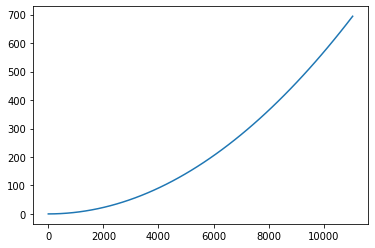

In [97]:
plt.plot(x0, z0)
plt.show()

In [98]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [99]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [100]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
#     Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None), tau_force[:3],flag=1).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 #+ Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################    

#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None,None),tau_force[3:])
    B_ =C3
    B=(B_ #+ C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [101]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [103]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [104]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [105]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [106]:
x0_

array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
         902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
        1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
        2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
        3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
        4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
        5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
        6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
        7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
        8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
        9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
        9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
       10827.11984764, 11052.68484446])

In [107]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [108]:
z0_

array([0.00000000e+00, 2.88842843e-01, 1.15537327e+00, 2.59959695e+00,
       4.62152338e+00, 7.22116580e+00, 1.03985413e+01, 1.41536706e+01,
       1.84865785e+01, 2.33972933e+01, 2.88858473e+01, 3.49522764e+01,
       4.15966205e+01, 4.88189230e+01, 5.66192315e+01, 6.49975970e+01,
       7.39540746e+01, 8.34887228e+01, 9.36016044e+01, 1.04292786e+02,
       1.15562337e+02, 1.27410331e+02, 1.39836847e+02, 1.52841966e+02,
       1.66425773e+02, 1.80588357e+02, 1.95329812e+02, 2.10650233e+02,
       2.26549722e+02, 2.43028382e+02, 2.60086322e+02, 2.77723654e+02,
       2.95940493e+02, 3.14736958e+02, 3.34113174e+02, 3.54069267e+02,
       3.74605368e+02, 3.95721612e+02, 4.17418136e+02, 4.39695085e+02,
       4.62552603e+02, 4.85990841e+02, 5.10009952e+02, 5.34610093e+02,
       5.59791427e+02, 5.85554119e+02, 6.11898337e+02, 6.38824254e+02,
       6.66332046e+02, 6.94421895e+02])

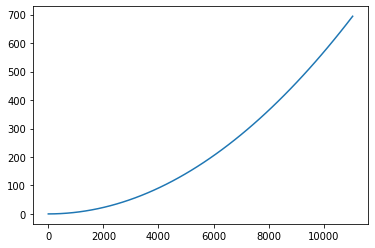

In [109]:
plt.plot(x0_, z0_)
plt.show()

In [110]:
init=1e-12
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=np.array([-0.055*i*init for i in range(node_N)])
        q0[(j-1)*node_N]=0
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([-0.0002*i*init for i in range(node_N)])
        q0[(j-1)*node_N]=0 
# q0[9*node_N-1]=0.13  # here

In [111]:
q0

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

### Vessle Simulation

In [112]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [113]:
vehicle=semisub('DPcontrol',1,0,40.0,0,0) 

In [114]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [115]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

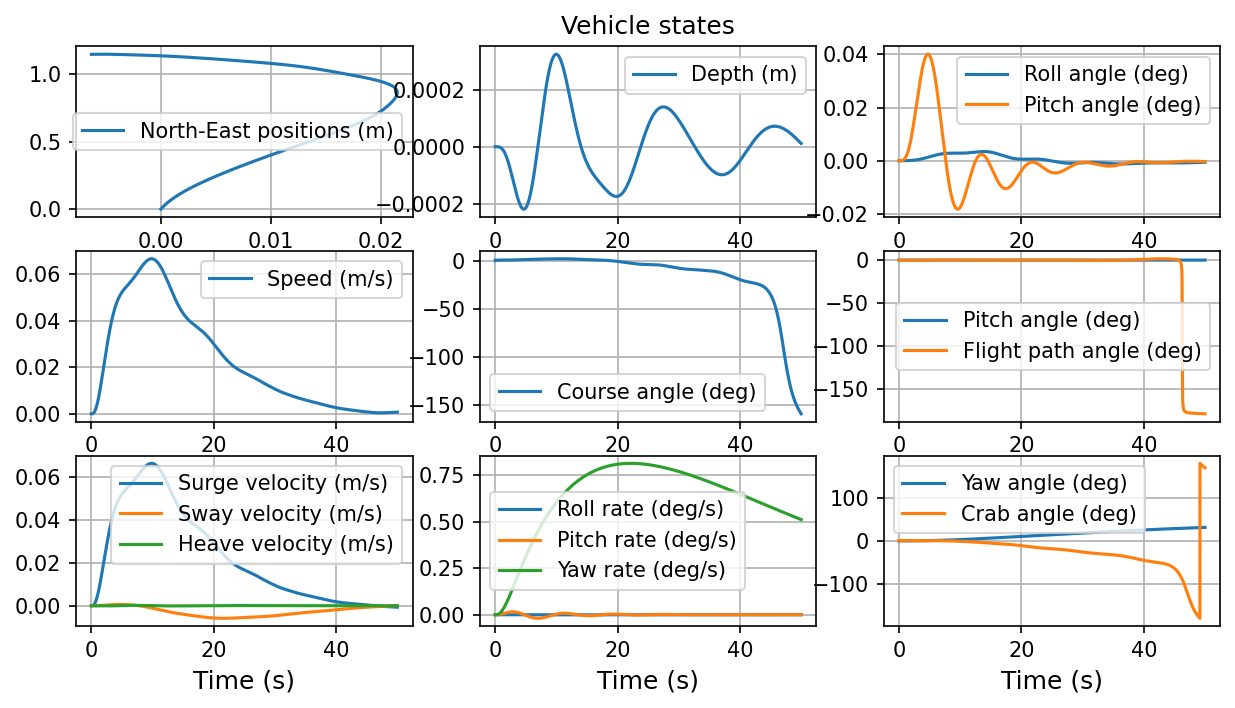

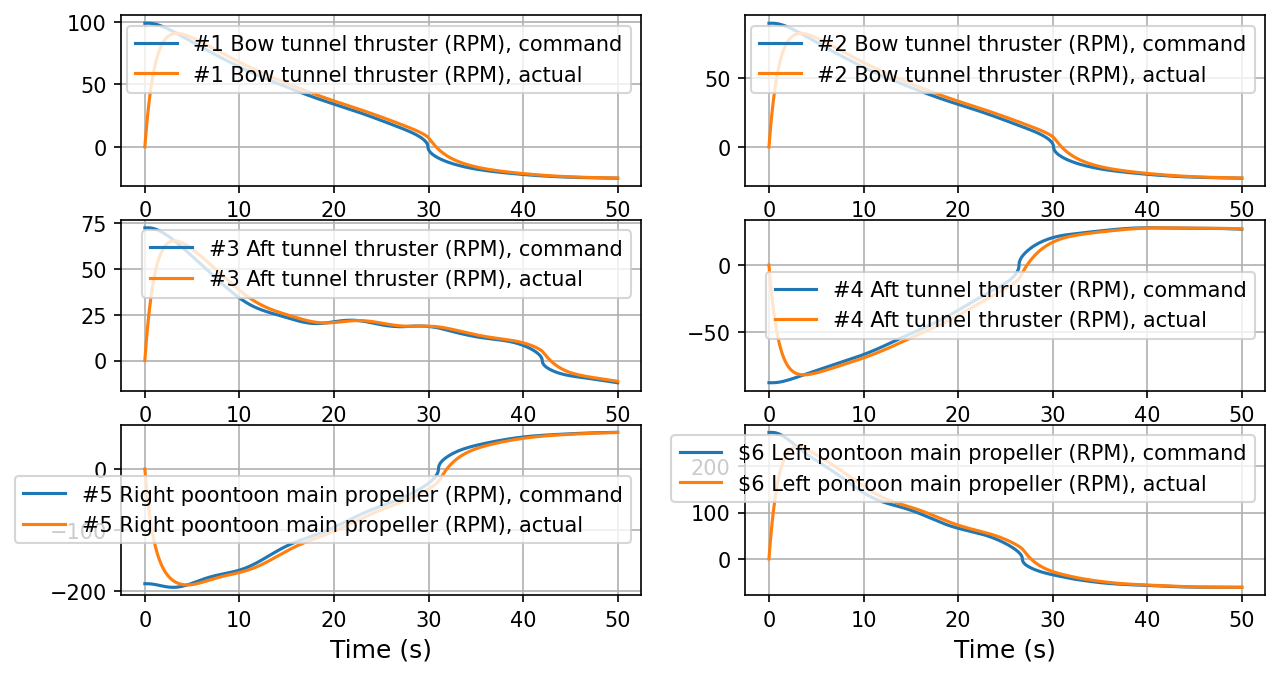

In [116]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [117]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

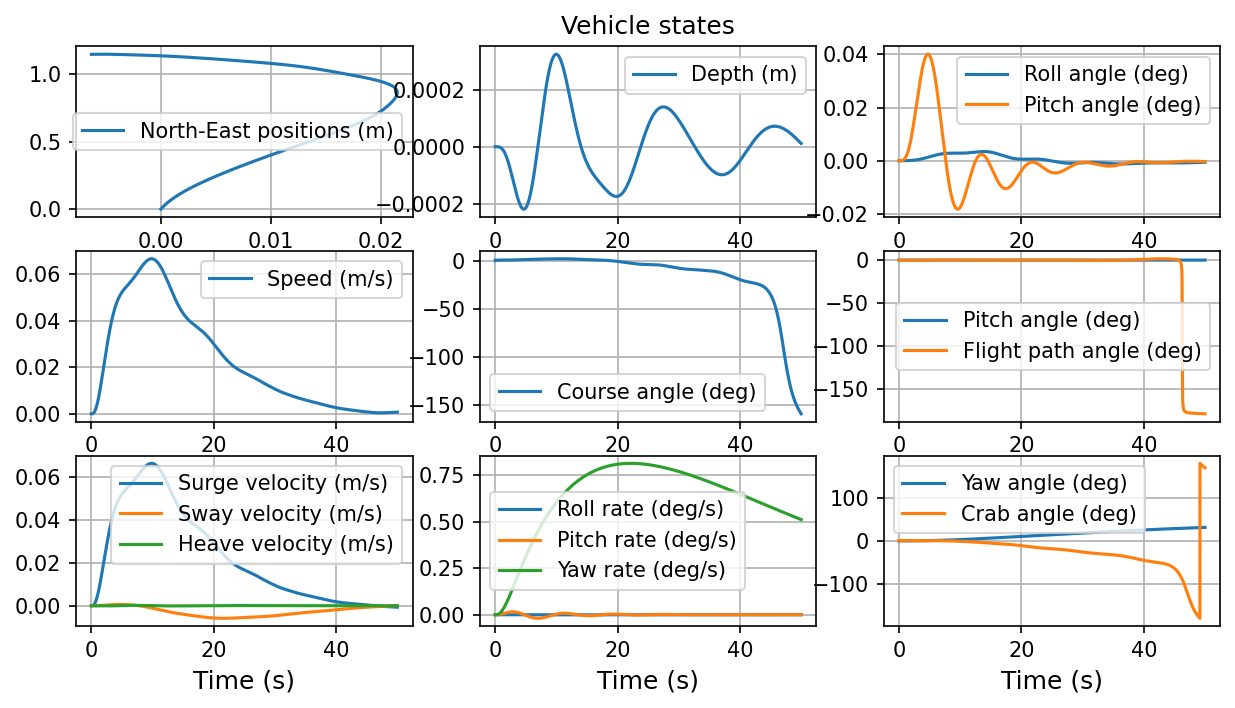

In [118]:
plotVehicleStates(simTime, simData, 3)

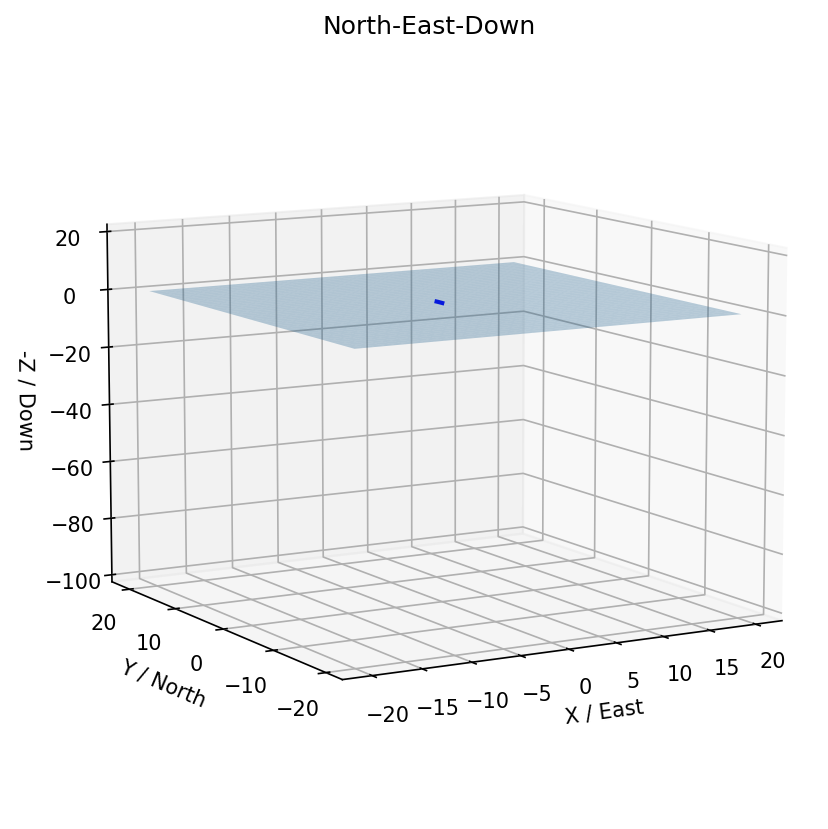

In [119]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [120]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [121]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### Dynamics

In [122]:
def grayscott1d(t, Q): # here
    print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
    force_schedule=1
#     print(type(n_))
    tau_force = force_schedule*np.array(n_) # [N]
#     tau_force[1]=0
#     tau_force[2]=0
#     tau_force[3]=0
#     tau_force[4]=0
#     tau_force[5]=0

    
#     Z0=np.dot(Re_b(Ret.astype(np.float64)),tau_force[:3].astype(np.float64)).astype(np.float64)
#     print(Z0)
    Z1 =d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None), tau_force[:3], flag=1).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T

    Z= (Z1 + Z2 #+Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################    

    RRRR=Re_b(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N)]
#                                              +[Ws[-1] + vessel_mass]
                                          
                                             ,RRRR),
                                   Z
                                  ).T 
#     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      

    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
   

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None,None),tau_force[3:])
    
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),[None,None,None]).T, 
                 ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),tau_force[:3]))
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ #+C0.squeeze()
#     print(B)   

    A2 = Irho_e(Ret).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
    

    hack=1e18
    hack=1
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################


#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111)
    return A1111

In [132]:
import scipy

In [189]:
ode15s = scipy.integrate.ode(grayscott1d)
ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# ode15s.set_integrator('vode',  order=32, nsteps=3000)
ode15s.set_initial_value(q0, 0)

In [190]:
us=ode15s.integrate(10)

0.0
2.8632436051226294e-16
3.701280832926765e-15
1.5498504508039078e-14
3.750201529476789e-14
5.95055260814967e-14
8.150903686822551e-14
3.015441447355136e-13
3.015441447355136e-13
3.015441447355136e-13
1.3651781383504753e-13
1.3651781383504753e-13
1.9152659080186955e-13
1.9152659080186955e-13
2.465353677686916e-13
3.756645959081006e-13
3.756645959081006e-13
5.047938240475096e-13
6.339230521869187e-13
8.340301353870864e-13
1.0341372185872541e-12
1.2342443017874218e-12
1.6977306647130101e-12
1.6977306647130101e-12
1.6977306647130101e-12
1.350115892518819e-12
1.350115892518819e-12
1.465987483250216e-12
1.465987483250216e-12
1.5818590739816132e-12
2.193170979472463e-12
2.193170979472463e-12
2.804482884963313e-12
2.804482884963313e-12
3.415794790454163e-12
4.0271066959450135e-12
4.638418601435864e-12
5.63168588059494e-12
7.394325915228787e-12
9.156965949862633e-12
9.156965949862633e-12
1.091960598449648e-11
1.2682246019130327e-11
1.605480118464218e-11
2.1355566267462564e-11
2.1355566267462

1.7504589663445544e-09
1.7543105777314704e-09
1.7581621891183864e-09
1.7581621891183864e-09
1.7620138005053025e-09
1.7620138005053025e-09
1.7658654118922185e-09
1.7658654118922185e-09
1.7729727921789697e-09
1.7729727921789697e-09
1.7800801724657208e-09
1.7800801724657208e-09
1.7916383913165006e-09
1.7916383913165006e-09
1.8031966101672805e-09
1.8031966101672805e-09
1.8031966101672805e-09
1.7945279460291955e-09
1.7974175007418904e-09
1.7974175007418904e-09
1.8003070554545853e-09
1.8053221162995964e-09
1.8103371771446075e-09
1.8153522379896186e-09
1.8256787690762888e-09
1.8256787690762888e-09
1.836005300162959e-09
1.836005300162959e-09
1.8463318312496293e-09
1.8463318312496293e-09
1.8566583623362995e-09
1.8566583623362995e-09
1.8669848934229695e-09
1.8773114245096395e-09
1.8876379555963095e-09
1.9037734248592397e-09
1.91990889412217e-09
1.9360443633851e-09
1.9607815672211604e-09
1.9607815672211604e-09
1.985518771057221e-09
1.985518771057221e-09
2.0102559748932813e-09
2.0102559748932813e-

3.572481996760537e-09
3.572481996760537e-09
3.594871059797792e-09
3.594871059797792e-09
3.6172601228350475e-09
3.639649185872303e-09
3.662038248909558e-09
3.6844273119468135e-09
3.706816374984069e-09
3.729205438021324e-09
3.729205438021324e-09
3.751594501058579e-09
3.751594501058579e-09
3.7739835640958336e-09
3.7739835640958336e-09
3.7963726271330885e-09
3.7963726271330885e-09
3.818761690170343e-09
3.818761690170343e-09
3.841150753207598e-09
3.841150753207598e-09
3.841150753207598e-09
3.824358955929657e-09
3.824358955929657e-09
3.8299562216889705e-09
3.8299562216889705e-09
3.8299562216889705e-09
3.8257582723694855e-09
3.8257582723694855e-09
3.827157588809314e-09
3.827157588809314e-09
3.828556905249143e-09
3.828556905249143e-09
3.828556905249143e-09
3.827507417919271e-09
3.827507417919271e-09
3.827857247029228e-09
3.827857247029228e-09
3.8277286660322285e-09
3.8277286660322285e-09
3.827949914145186e-09
3.827949914145186e-09
3.827949914145186e-09
3.827783978060468e-09
3.827783978060468e-

5.228730604164614e-09
5.228730604164614e-09
5.237666058821147e-09
5.237666058821147e-09
5.246601513477681e-09
5.246601513477681e-09
5.255536968134214e-09
5.2644724227907475e-09
5.273407877447281e-09
5.282343332103814e-09
5.291278786760348e-09
5.300214241416881e-09
5.31774420556631e-09
5.335274169715738e-09
5.352804133865167e-09
5.370334098014595e-09
5.387864062164024e-09
5.414262085568245e-09
5.414262085568245e-09
5.440660108972466e-09
5.440660108972466e-09
5.467058132376687e-09
5.467058132376687e-09
5.493456155780908e-09
5.519854179185129e-09
5.54625220258935e-09
5.587614867746682e-09
5.587614867746682e-09
5.628977532904014e-09
5.628977532904014e-09
5.670340198061346e-09
5.670340198061346e-09
5.711702863218678e-09
5.711702863218678e-09
5.7530655283760095e-09
5.7530655283760095e-09
5.7944281935333415e-09
5.7944281935333415e-09
5.8357908586906735e-09
5.8357908586906735e-09
5.8771535238480054e-09
5.8771535238480054e-09
5.918516189005337e-09
5.918516189005337e-09
5.918516189005337e-09
5.8

6.590649234261815e-09
6.592865272670588e-09
6.5950813110793605e-09
6.597297349488133e-09
6.597297349488133e-09
6.595635320681554e-09
6.595635320681554e-09
6.595434936537086e-09
6.595434936537086e-09
6.595788561994811e-09
6.595788561994811e-09
6.595788561994811e-09
6.595523342901517e-09
6.595523342901517e-09
6.595611749265948e-09
6.595611749265948e-09
6.595700155630379e-09
6.595700155630379e-09
6.595700155630379e-09
6.595633850857056e-09
6.595633850857056e-09
6.595655952448164e-09
6.595655952448164e-09
6.595678054039272e-09
6.595678054039272e-09
6.595678054039272e-09
6.5956614778459405e-09
6.5956614778459405e-09
6.595667003243717e-09
6.595667003243717e-09
6.595672528641494e-09
6.595678054039271e-09
6.595683579437048e-09
6.595692770843692e-09
6.595709898969135e-09
6.595709898969135e-09
6.595709898969135e-09
6.595697052875053e-09
6.595697052875053e-09
6.5956955570219475e-09
6.5956955570219475e-09
6.595693328079343e-09
6.595693885314994e-09
6.595693885314994e-09
6.595694442550645e-09
6.595

7.734321058447348e-09
7.734321058447348e-09
7.761208756602174e-09
7.761208756602174e-09
7.788096454757e-09
7.788096454757e-09
7.814984152911826e-09
7.814984152911826e-09
7.841871851066652e-09
7.841871851066652e-09
7.868759549221479e-09
7.868759549221479e-09
7.895647247376305e-09
7.895647247376305e-09
7.922534945531131e-09
7.922534945531131e-09
7.949422643685957e-09
7.949422643685957e-09
7.976310341840783e-09
7.976310341840783e-09
8.00319803999561e-09
8.00319803999561e-09
8.00319803999561e-09
7.98303226637949e-09
7.98303226637949e-09
7.989754190918197e-09
7.989754190918197e-09
7.996476115456904e-09
7.996476115456904e-09
8.003198039995611e-09
8.009919964534318e-09
8.016641889073025e-09
8.023363813611732e-09
8.030085738150439e-09
8.036807662689146e-09
8.049174577977588e-09
8.06154149326603e-09
8.073908408554471e-09
8.086275323842913e-09
8.098642239131354e-09
8.118131655580799e-09
8.118131655580799e-09
8.137621072030244e-09
8.137621072030244e-09
8.157110488479689e-09
8.157110488479689e-09


9.402779590908247e-09
9.413644894578144e-09
9.413644894578144e-09
9.42451019824804e-09
9.42451019824804e-09
9.435375501917938e-09
9.435375501917938e-09
9.446240805587835e-09
9.446240805587835e-09
9.457106109257732e-09
9.457106109257732e-09
9.467971412927629e-09
9.478836716597526e-09
9.489702020267422e-09
9.50056732393732e-09
9.511432627607216e-09
9.522297931277113e-09
9.540500207846725e-09
9.540500207846725e-09
9.558702484416337e-09
9.558702484416337e-09
9.576904760985948e-09
9.576904760985948e-09
9.59510703755556e-09
9.59510703755556e-09
9.613309314125172e-09
9.631511590694784e-09
9.649713867264395e-09
9.667916143834007e-09
9.686118420403619e-09
9.70432069697323e-09
9.722522973542842e-09
9.740725250112454e-09
9.758927526682066e-09
9.758927526682066e-09
9.777129803251677e-09
9.777129803251677e-09
9.795332079821289e-09
9.795332079821289e-09
9.8135343563909e-09
9.8135343563909e-09
9.831736632960512e-09
9.831736632960512e-09
9.849938909530124e-09
9.849938909530124e-09
9.868141186099736e-0

1.0030900158744359e-08
1.0030900435699435e-08
1.0030900435699435e-08
1.003090071265451e-08
1.0030901150881688e-08
1.0030901824791881e-08
1.0030901824791881e-08
1.0030902869030978e-08
1.0030902869030978e-08
1.0030903913270075e-08
1.0030903913270075e-08
1.0030904957509171e-08
1.0030904957509171e-08
1.0030904555281225e-08
1.0030904555281225e-08
1.0030905197292375e-08
1.0030905197292375e-08
1.0030905839303525e-08
1.0030906481314675e-08
1.0030907123325826e-08
1.0030908327866864e-08
1.0030910734376885e-08
1.0030910734376885e-08
1.0030908929494369e-08
1.0030908929494369e-08
1.0030909531121873e-08
1.0030909531121873e-08
1.0030909531121873e-08
1.0030909079901245e-08
1.0030909079901245e-08
1.0030909023794684e-08
1.0030909023794684e-08
1.0030909118095e-08
1.0030909118095e-08
1.0030909212395315e-08
1.0030909367068742e-08
1.003090952174217e-08
1.0030909858020374e-08
1.0030909858020374e-08
1.0030910194298578e-08
1.0030910194298578e-08
1.0030910530576783e-08
1.0030910866854987e-08
1.0030911203133192e

1.0031282243713016e-08
1.0031282243713016e-08
1.0031310545499412e-08
1.0031310545499412e-08
1.0031338847285809e-08
1.0031338847285809e-08
1.0031367149072205e-08
1.0031395450858602e-08
1.0031446690210565e-08
1.0031446690210565e-08
1.0031497929562527e-08
1.003154916891449e-08
1.0031600408266453e-08
1.003181855383341e-08
1.003181855383341e-08
1.0032036699400369e-08
1.0032036699400369e-08
1.0032036699400369e-08
1.003187309022515e-08
1.003187309022515e-08
1.0031927626616889e-08
1.0031927626616889e-08
1.0031982163008628e-08
1.0032167979192664e-08
1.0032167979192664e-08
1.0032353795376701e-08
1.0032539611560738e-08
1.0032725427744774e-08
1.0033121489789227e-08
1.0033121489789227e-08
1.0033121489789227e-08
1.0032824443255888e-08
1.0032824443255888e-08
1.0032923458767002e-08
1.0033022474278116e-08
1.0033197974430249e-08
1.0033373474582382e-08
1.0033715949818942e-08
1.0033715949818942e-08
1.0034463797747493e-08
1.0034463797747493e-08
1.0035211645676043e-08
1.0035211645676043e-08
1.00352116456760

1.052869064658252e-08
1.0528726459420208e-08
1.0528762272257897e-08
1.0528798085095586e-08
1.0528863963144135e-08
1.0528863963144135e-08
1.0528863963144135e-08
1.0528814554607723e-08
1.0528814554607723e-08
1.0528831024119859e-08
1.0528831024119859e-08
1.0528847493631995e-08
1.0528904715075936e-08
1.0528904715075936e-08
1.0528961936519877e-08
1.0529019157963818e-08
1.052907637940776e-08
1.0529167975442014e-08
1.0529347302681284e-08
1.0529526629920554e-08
1.0529526629920554e-08
1.0529705957159824e-08
1.0529705957159824e-08
1.0529885284399095e-08
1.0529885284399095e-08
1.0530183541590282e-08
1.0530183541590282e-08
1.0530481798781469e-08
1.0530481798781469e-08
1.0530481798781469e-08
1.0530258105888079e-08
1.0530332670185875e-08
1.0530407234483672e-08
1.0530762570978721e-08
1.0530762570978721e-08
1.053111790747377e-08
1.053111790747377e-08
1.0530975792047352e-08
1.0530975792047352e-08
1.0531189013115983e-08
1.0531402234184615e-08
1.0531918228082022e-08
1.0533064407374393e-08
1.0533064407374

1.1199062227390154e-08
1.1216584107985015e-08
1.1216584107985015e-08
1.1216584107985015e-08
1.120344269753887e-08
1.1207823167687586e-08
1.1207823167687586e-08
1.1212203637836302e-08
1.1212203637836302e-08
1.1216584107985018e-08
1.1216584107985018e-08
1.1216584107985018e-08
1.121329875537348e-08
1.121329875537348e-08
1.1214393872910659e-08
1.1214393872910659e-08
1.1214063800941777e-08
1.1214063800941777e-08
1.1214828846510074e-08
1.1214828846510074e-08
1.1215593892078371e-08
1.1215593892078371e-08
1.1216358937646668e-08
1.1217123983214965e-08
1.1217123983214965e-08
1.1217123983214965e-08
1.1216550199038743e-08
1.1216741460430817e-08
1.1216741460430817e-08
1.1216741460430817e-08
1.1216598014386762e-08
1.121664582973478e-08
1.12166936450828e-08
1.1216741460430819e-08
1.121684218816448e-08
1.121684218816448e-08
1.121694291589814e-08
1.121694291589814e-08
1.1216908332206013e-08
1.1216908332206013e-08
1.1216974476247547e-08
1.1216974476247547e-08
1.1217040620289081e-08
1.1217040620289081e-0

1.1219017596397097e-08
1.1219014886494939e-08
1.1219014886494939e-08
1.1219020312612929e-08
1.1219020312612929e-08
1.1219025738730918e-08
1.1219031164848908e-08
1.1219036590966898e-08
1.1219049630878452e-08
1.1219049630878452e-08
1.1219062670790007e-08
1.1219062670790007e-08
1.1219075710701562e-08
1.1219075710701562e-08
1.1219069626515842e-08
1.1219069626515842e-08
1.1219076582241677e-08
1.1219076582241677e-08
1.1219083537967512e-08
1.1219090493693347e-08
1.1219097449419182e-08
1.1219110730136183e-08
1.1219110730136183e-08
1.1219124010853185e-08
1.1219124010853185e-08
1.1219137291570186e-08
1.1219137291570186e-08
1.1219150572287187e-08
1.1219163853004189e-08
1.121917713372119e-08
1.1219190414438192e-08
1.1219216573241449e-08
1.1219216573241449e-08
1.1219242732044706e-08
1.1219242732044706e-08
1.1219268890847964e-08
1.1219268890847964e-08
1.1219295049651221e-08
1.1219321208454478e-08
1.1219366776173784e-08
1.1219366776173784e-08
1.1219366776173784e-08
1.1219332600384304e-08
1.1219332600

1.1248887151407593e-08
1.124892336837642e-08
1.1248959585345245e-08
1.1249031791690078e-08
1.124910399803491e-08
1.1249264502909608e-08
1.1249542431153306e-08
1.1249542431153306e-08
1.1249820359397003e-08
1.12500982876407e-08
1.1250649828078436e-08
1.1251629448148385e-08
1.1251629448148385e-08
1.1251629448148385e-08
1.1250894733095924e-08
1.1250894733095924e-08
1.1251139638113411e-08
1.1251139638113411e-08
1.1251384543130899e-08
1.1251629448148387e-08
1.1252060087613405e-08
1.1252490727078424e-08
1.1252490727078424e-08
1.1252490727078424e-08
1.125216774747966e-08
1.125216774747966e-08
1.1252275407345915e-08
1.1252275407345915e-08
1.125238306721217e-08
1.1252490727078425e-08
1.1252682995816719e-08
1.1252975746946102e-08
1.1253268498075484e-08
1.1253561249204867e-08
1.125385400033425e-08
1.1254304949863796e-08
1.1254304949863796e-08
1.1254304949863796e-08
1.1253966737716637e-08
1.1253966737716637e-08
1.1254079475099025e-08
1.1254079475099025e-08
1.1254192212481412e-08
1.125436316749806e-

1.1381035089417297e-08
1.1381035089417297e-08
1.1381045076684188e-08
1.1381045076684188e-08
1.1381055063951079e-08
1.1381072367008058e-08
1.1381072367008058e-08
1.1381089670065037e-08
1.1381089670065037e-08
1.1381106973122016e-08
1.1381124276178994e-08
1.1381153950489115e-08
1.1381202697888739e-08
1.1381251445288362e-08
1.1381329033491805e-08
1.1381514655861594e-08
1.1381514655861594e-08
1.1381514655861594e-08
1.1381375439084253e-08
1.1381375439084253e-08
1.13814218446767e-08
1.13814218446767e-08
1.1381468250269147e-08
1.1381554197088356e-08
1.1381554197088356e-08
1.1381640143907566e-08
1.1381640143907566e-08
1.138160907174371e-08
1.138160907174371e-08
1.1381663946399065e-08
1.1381663946399065e-08
1.1381718821054419e-08
1.1381718821054419e-08
1.1381773695709773e-08
1.1381828570365127e-08
1.1381938604901393e-08
1.1381938604901393e-08
1.1381938604901393e-08
1.1381856078999194e-08
1.1381856078999194e-08
1.1381883587633261e-08
1.1381883587633261e-08
1.1381911096267328e-08
1.138193860490139

1.138449446614534e-08
1.138449446614534e-08
1.1384458834486692e-08
1.1384458834486692e-08
1.1384470711706241e-08
1.1384470711706241e-08
1.138448258892579e-08
1.1384501776958696e-08
1.1384501776958696e-08
1.1384520964991602e-08
1.1384520964991602e-08
1.1384540153024509e-08
1.1384540153024509e-08
1.1384540153024509e-08
1.1384525761999829e-08
1.1384525761999829e-08
1.1384530559008056e-08
1.1384530559008056e-08
1.1384535356016282e-08
1.1384542779913617e-08
1.1384542779913617e-08
1.1384550203810951e-08
1.1384550203810951e-08
1.1384550203810951e-08
1.138454463588795e-08
1.138454463588795e-08
1.1384546491862283e-08
1.1384546491862283e-08
1.1384548347836616e-08
1.1384551830036597e-08
1.1384551830036597e-08
1.1384555312236578e-08
1.1384555312236578e-08
1.138455879443656e-08
1.138456227663654e-08
1.1384568251695518e-08
1.1384579276563072e-08
1.1384590301430626e-08
1.1384608079646634e-08
1.1384645404308602e-08
1.1384645404308602e-08
1.1384645404308602e-08
1.1384617410812125e-08
1.1384617410812125

1.139466137738341e-08
1.139466137738341e-08
1.1394854811010866e-08
1.1394854811010866e-08
1.1394766593170142e-08
1.1394766593170142e-08
1.1394871808956875e-08
1.1394871808956875e-08
1.1394977024743607e-08
1.1395153681654204e-08
1.1395153681654204e-08
1.1395330338564801e-08
1.1395330338564801e-08
1.1395506995475398e-08
1.1395506995475398e-08
1.1395683652385995e-08
1.1395860309296592e-08
1.1396771187430988e-08
1.1396771187430988e-08
1.1396408230115118e-08
1.1396408230115118e-08
1.1396956150933643e-08
1.1396956150933643e-08
1.1396779471587258e-08
1.1396779471587258e-08
1.1397150713059398e-08
1.1397150713059398e-08
1.1397521954531538e-08
1.1397893196003678e-08
1.1397893196003678e-08
1.1398264437475818e-08
1.1398635678947959e-08
1.1399006920420099e-08
1.1399799141893321e-08
1.1399799141893321e-08
1.1399799141893321e-08
1.1399204975788404e-08
1.1399204975788404e-08
1.139940303115671e-08
1.139940303115671e-08
1.1399601086525016e-08
1.1400028709015953e-08
1.1400028709015953e-08
1.1399898543172

In [165]:
tspan = (0., 14e-9)

In [166]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0.0
9.176168320655896e-12
1.8352336641311793e-10
2.752850496196769e-10
7.340934656524717e-10
8.156594062805241e-10
9.176168320655896e-10
9.176168320655896e-10
9.840170284526002e-11
1.4760255426789002e-10
3.936068113810401e-10
4.3734090153448894e-10
4.920085142263001e-10
4.920085142263001e-10
5.904102170715601e-10
6.396110684941901e-10
8.856153256073401e-10
9.29349415760789e-10
9.840170284526001e-10
9.840170284526001e-10
1.0842700092066518e-09
1.1343964995836776e-09
1.3850289514688066e-09
1.4295858318039408e-09
1.4852819322228582e-09
1.4852819322228582e-09
1.5830413419654334e-09
1.631921046836721e-09
1.8763195711931588e-09
1.9197681977454143e-09
1.974078980935734e-09
1.974078980935734e-09
2.0743179752964377e-09
2.1244374724767895e-09
2.3750349583785486e-09
2.4195856225388616e-09
2.4752739527392523e-09
2.4752739527392523e-09
2.062037804768344e-09
2.106017216684649e-09
2.325914276266175e-09
2.365007086858446e-09
2.413873100098785e-09
2.413873100098785e-09
2.5013019308979357e-09
2.54501634

1.3477516590766987e-08
1.3474578449130868e-08
1.3474758883325699e-08
1.3475661054299858e-08
1.347582144025082e-08
1.3476021922689523e-08
1.3476021922689523e-08
1.3476382791079187e-08
1.3476563225274017e-08
1.3477465396248177e-08
1.347762578219914e-08
1.3477826264637841e-08
1.3477826264637841e-08
1.3476319255249015e-08
1.3476467921528761e-08
1.3477211252927492e-08
1.3477343400731712e-08
1.3477508585486984e-08
1.3477508585486984e-08
1.347623927946985e-08
1.3476347957860014e-08
1.3476891349810835e-08
1.3476987952824313e-08
1.3477108706591162e-08
1.3477108706591162e-08
1.3476121397517614e-08
1.347617113493166e-08
1.347641982200189e-08
1.3476464033036598e-08
1.3476519296829982e-08
1.3476519296829982e-08
1.3476618771658074e-08
1.347666850907212e-08
1.347691719614235e-08
1.3476961407177057e-08
1.3477016670970441e-08
1.3477016670970441e-08
1.3477113824254695e-08
1.3477162400896822e-08
1.3477405284107456e-08
1.3477448463344902e-08
1.3477502437391709e-08
1.3477502437391709e-08
1.3477036101627291

1.3497153287825262e-08
1.3497153295507628e-08
1.3497153295507628e-08
1.3497153433790207e-08
1.3497153502931496e-08
1.3497153848637943e-08
1.3497153910096867e-08
1.3497153986920522e-08
1.3497153986920522e-08
1.3497154793980496e-08
1.3497155197510482e-08
1.3497157215160418e-08
1.349715757385374e-08
1.3497158022220391e-08
1.3497158022220391e-08
1.3497162925729422e-08
1.3497165377483937e-08
1.3497177636256513e-08
1.349717981559386e-08
1.3497182539765544e-08
1.3497182539765544e-08
1.3497159209798644e-08
1.349715980358777e-08
1.3497162772533399e-08
1.3497163300345956e-08
1.3497163960111651e-08
1.3497163960111651e-08
1.3497165147689903e-08
1.349716574147903e-08
1.3497168710424659e-08
1.3497169238237216e-08
1.3497169898002911e-08
1.3497169898002911e-08
1.3497175335712824e-08
1.3497178054567782e-08
1.3497191648842568e-08
1.3497194065602529e-08
1.3497197086552482e-08
1.3497197086552482e-08
1.3497171710681033e-08
1.3497172617020094e-08
1.3497177148715398e-08
1.349717795435012e-08
1.34971789613935

1.3497203463539772e-08
1.3497203463539772e-08
1.3497203462553483e-08
1.3497203462602482e-08
1.3497203462847473e-08
1.3497203462891027e-08
1.3497203462945469e-08
1.3497203462945469e-08
1.3497203463043465e-08
1.3497203463092464e-08
1.3497203463337455e-08
1.3497203463381009e-08
1.3497203463435451e-08
1.3497203463435451e-08
1.3497203463529215e-08
1.3497203463576096e-08
1.3497203463810508e-08
1.3497203463852181e-08
1.3497203463904272e-08
1.3497203463904272e-08
1.3497203463454203e-08
1.349720346346358e-08
1.3497203463510463e-08
1.3497203463518798e-08
1.3497203463529215e-08
1.3497203463529215e-08
1.3497203463547967e-08
1.3497203463557344e-08
1.3497203463604227e-08
1.3497203463612562e-08
1.349720346362298e-08
1.349720346362298e-08
1.3497203463644678e-08
1.3497203463655529e-08
1.3497203463709777e-08
1.349720346371942e-08
1.3497203463731476e-08
1.3497203463731476e-08
1.3497203463627602e-08
1.3497203463629914e-08
1.3497203463641472e-08
1.3497203463643526e-08
1.3497203463646094e-08
1.3497203463646

1.3497203463717845e-08
1.3497203463717859e-08
1.3497203463717867e-08
1.3497203463717902e-08
1.3497203463717907e-08
1.3497203463717915e-08
1.3497203463717915e-08
1.3497203463717855e-08
1.349720346371786e-08
1.3497203463717885e-08
1.349720346371789e-08
1.3497203463717895e-08
1.3497203463717895e-08
1.3497203463717905e-08
1.349720346371791e-08
1.3497203463717935e-08
1.349720346371794e-08
1.3497203463717945e-08
1.3497203463717945e-08
1.3497203463717956e-08
1.3497203463717961e-08
1.349720346371799e-08
1.3497203463717994e-08
1.3497203463718001e-08
1.3497203463718001e-08
1.3497203463717953e-08
1.3497203463717958e-08
1.349720346371798e-08
1.3497203463717983e-08
1.3497203463717988e-08
1.3497203463717988e-08
1.3497203463717996e-08
1.3497203463718001e-08
1.3497203463718022e-08
1.3497203463718026e-08
1.349720346371803e-08
1.349720346371803e-08
1.349720346371804e-08
1.3497203463718046e-08
1.3497203463718072e-08
1.3497203463718077e-08
1.3497203463718082e-08
1.3497203463718082e-08
1.3497203463718037e-

In [167]:
# key takeaway: you can calibrate the model by tuning the hack and bc(init) 

### Results

In [168]:
fin=us

In [169]:
fin

  message: 'Required step size is less than spacing between numbers.'
     nfev: 1634
     njev: 0
      nlu: 0
      sol: None
   status: -1
  success: False
        t: array([0.00000000e+00, 4.92008514e-10, 9.84017028e-10, 1.48528193e-09,
       1.97407898e-09, 2.41387310e-09, 2.85101725e-09, 3.29224798e-09,
       3.72413847e-09, 4.14790784e-09, 4.59985014e-09, 5.01038797e-09,
       5.46057352e-09, 5.86273067e-09, 6.26419880e-09, 6.74322706e-09,
       7.17461343e-09, 7.59528712e-09, 8.06578963e-09, 8.49306924e-09,
       8.93153404e-09, 9.35256954e-09, 9.77764787e-09, 1.01959096e-08,
       1.05828733e-08, 1.09130940e-08, 1.12194654e-08, 1.15727594e-08,
       1.19270681e-08, 1.21650988e-08, 1.23640378e-08, 1.25629768e-08,
       1.27783234e-08, 1.30387253e-08, 1.32925342e-08, 1.33434471e-08,
       1.33943601e-08, 1.34138680e-08, 1.34333760e-08, 1.34437812e-08,
       1.34541864e-08, 1.34610016e-08, 1.34623646e-08, 1.34637277e-08,
       1.34713359e-08, 1.34727767e-08, 1.34742176

In [170]:
t=fin.t

In [171]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


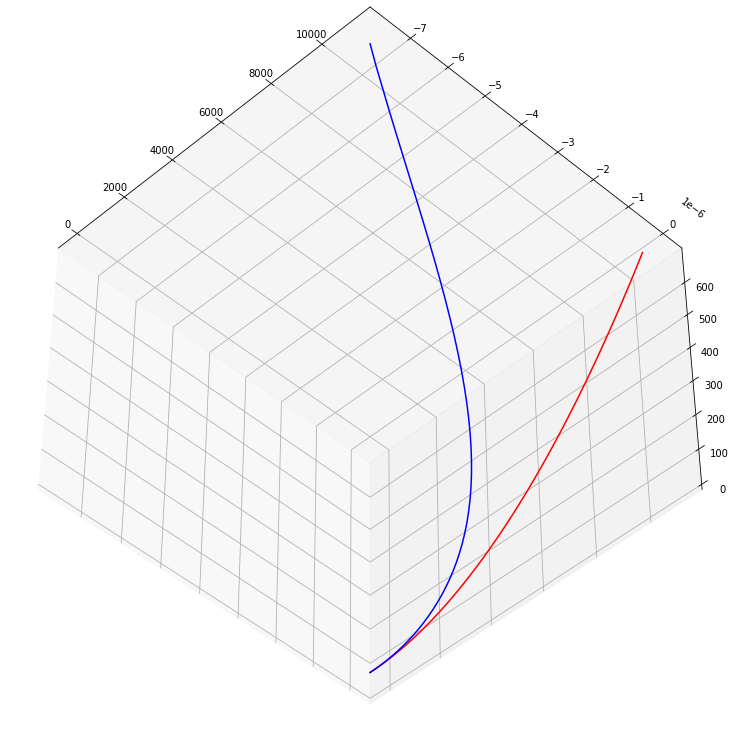

In [172]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
# ax.view_init(0,-90)
plt.show()

In [173]:
X,Y,Z

(array([    0.        ,   225.56499682,   451.12999364,   676.69499044,
          902.25998724,  1127.82498403,  1353.38998081,  1578.95497758,
         1804.51997435,  2030.0849711 ,  2255.64996785,  2481.21496459,
         2706.77996132,  2932.34495804,  3157.90995475,  3383.47495146,
         3609.03994815,  3834.60494484,  4060.16994151,  4285.73493818,
         4511.29993483,  4736.86493148,  4962.42992812,  5187.99492474,
         5413.55992135,  5639.12491796,  5864.68991455,  6090.25491112,
         6315.81990769,  6541.38490424,  6766.94990077,  6992.51489729,
         7218.07989379,  7443.64489028,  7669.20988675,  7894.7748832 ,
         8120.33987963,  8345.90487604,  8571.46987244,  8797.03486881,
         9022.59986517,  9248.16486152,  9473.72985785,  9699.29485417,
         9924.85985048, 10150.42484678, 10375.98984308, 10601.55483939,
        10827.11983569, 11052.68483202]),
 array([ 0.00000000e+00, -6.14053488e-10, -2.57008743e-09, -6.04860142e-09,
        -1.1245207

In [174]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [175]:
us=fin.T

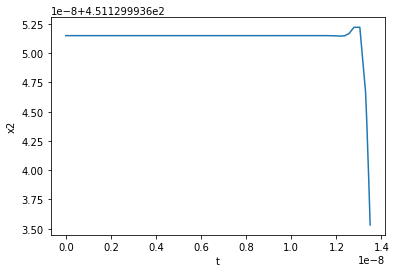

In [176]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

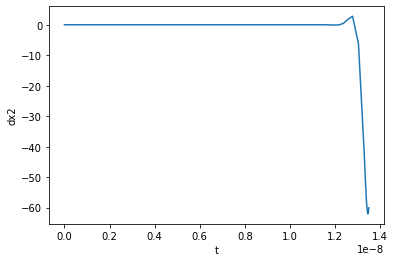

In [177]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

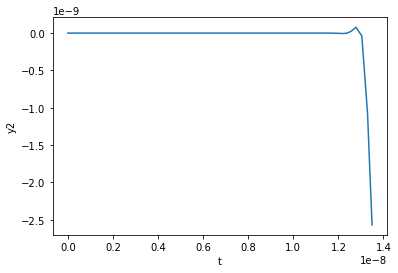

In [178]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

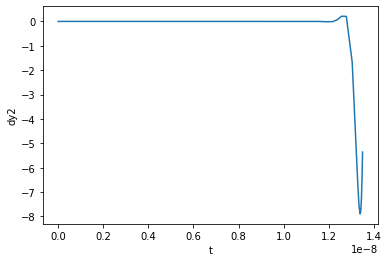

In [179]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

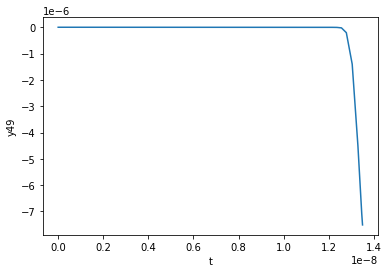

In [180]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

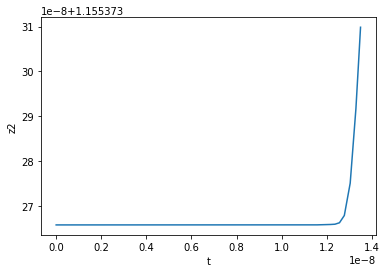

In [181]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

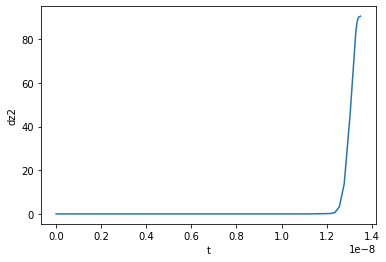

In [182]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

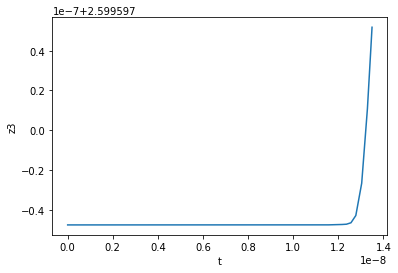

In [183]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

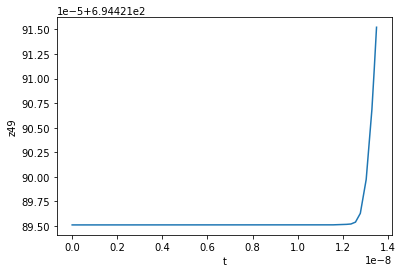

In [184]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

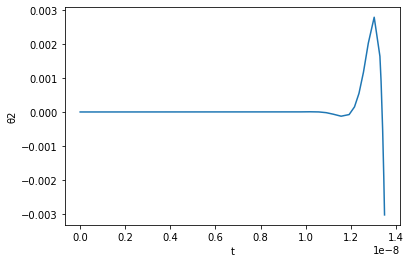

In [185]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

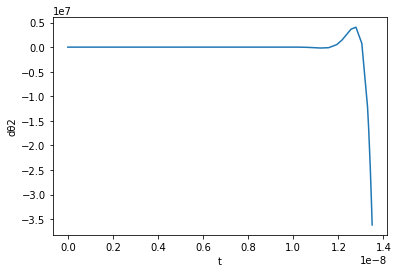

In [186]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

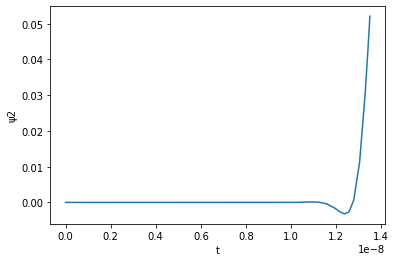

In [187]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

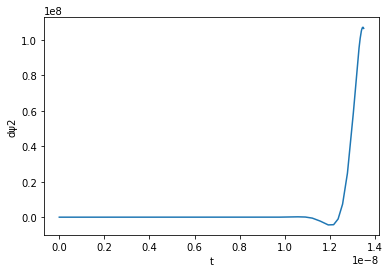

In [188]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()